In [14]:
!pip install resampy

#1. Import Libraries

In [15]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.ensemble import BalancedRandomForestClassifier

#2. Mount The Drive + Load the Sataset

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
DATASET_PATH = '/content/drive/MyDrive/archive'

In [18]:
metadata = pd.read_csv(os.path.join(DATASET_PATH, 'UrbanSound8K.csv'))
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [19]:
metadata['class'].value_counts()

,count
class,
dog_bark,1000
children_playing,1000
air_conditioner,1000
street_music,1000
engine_idling,1000
jackhammer,1000
drilling,1000
siren,929
car_horn,429


In [20]:
#Map only for the critical LABELS
label_mapping = {
    'siren': 'siren',
    'car_horn': 'traffic',
    'engine_idling': 'traffic',
    'street_music': 'others',
    'dog_bark': 'others',
    'air_conditioner': 'others',
    'children_playing': 'others',
    'drilling': 'others',
    'gun_shot': 'others',
    'jackhammer': 'others'
}

In [21]:
metadata['target'] = metadata['class'].map(label_mapping)
metadata['target'].value_counts()

,count
target,
others,6374
traffic,1429
siren,929


In [22]:
filtered_data = metadata[metadata['target'].isin(['siren', 'traffic', 'others'])]
print(filtered_data['target'].value_counts())

target
others     6374
traffic    1429
siren       929
Name: count, dtype: int64


#3. Extract Features

In [23]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6, fmin=50).T, axis=0)  # Reduced n_bands, set a reasonable fmin
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    feature_vector = np.hstack([mfccs, chroma, mel, spectral_contrast, spectral_centroid])
    return feature_vector

#4. Augmentation

In [24]:
def remove_silence(y, sr):
    non_silent_intervals = librosa.effects.split(y, top_db=20)
    y_trimmed = np.concatenate([y[start:end] for start, end in non_silent_intervals])
    return y_trimmed

def augment_audio(y, sr):
    y_silence_removed = remove_silence(y, sr)
    y_stretch = librosa.effects.time_stretch(y_silence_removed, rate=0.8)
    return y_stretch

#5. Apply the feature selection and augmentation

In [25]:
def parser(df):
    features = []
    labels = []

    for i in range(len(df)):
        file_name = os.path.join(DATASET_PATH, 'fold' + str(df["fold"][i]), df["slice_file_name"][i])
        y, sr = librosa.load(file_name, res_type='kaiser_fast')

        augmented_y = augment_audio(y, sr)

        features.append(extract_features_from_array(augmented_y, sr))

        labels.append(df["target"].iloc[i])

    return np.array(features), pd.get_dummies(labels).values

def extract_features_from_array(y, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    feature_vector = np.hstack([mfccs, chroma, mel, spectral_contrast, spectral_centroid])
    return feature_vector

In [26]:
features, labels = parser(filtered_data)
print(features.shape)
print(labels.shape)

data = pd.DataFrame(features, columns=['feature_' + str(i) for i in range(features.shape[1])])
data['label'] = np.argmax(labels, axis=1)
data.to_csv('extracted_dataset.csv', index=False)
data.head()


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1654
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1379
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:

(8732, 161)
(8732, 3)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,label
0,-183.867126,64.305382,-133.963608,-56.988361,-26.028252,-24.034170,-12.167013,21.154287,5.875556,14.372552,...,1.699501e-07,17.479379,10.395378,21.242926,19.628372,20.433412,21.722197,40.755149,2033.637062,0
1,-461.745758,106.974564,-53.274998,60.225922,0.736511,17.049057,2.488506,10.580058,-1.050853,11.824901,...,9.730453e-10,13.436018,11.940644,15.692765,16.537208,18.896476,22.868455,49.899946,2095.047225,0
2,-496.576447,119.380226,-47.113014,51.378319,0.311696,24.253279,9.428707,8.872616,-0.738319,10.971484,...,9.717863e-10,12.698985,11.292737,14.248345,17.068293,18.070515,21.961495,48.655548,1791.571839,0
3,-449.885284,98.767090,-36.036182,52.649754,2.067643,13.971757,2.406556,7.311208,-1.528201,10.083519,...,3.516187e-10,13.199526,11.500486,18.363733,16.878583,18.547320,23.378245,48.219080,2202.754697,0
4,-484.716827,112.039894,-52.245663,59.713055,3.317644,25.135527,2.806923,9.273830,3.293108,10.216081,...,1.078837e-09,13.783502,11.934360,14.926701,16.360208,18.379062,21.827361,48.381064,1944.224016,0


In [27]:
data = pd.DataFrame(features, columns=['feature_' + str(i) for i in range(features.shape[1])])
data['label'] = np.argmax(labels, axis=1)
data.to_csv('extracted_dataset.csv', index=False)
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,label
0,-183.867126,64.305382,-133.963608,-56.988361,-26.028252,-24.034170,-12.167013,21.154287,5.875556,14.372552,...,1.699501e-07,17.479379,10.395378,21.242926,19.628372,20.433412,21.722197,40.755149,2033.637062,0
1,-461.745758,106.974564,-53.274998,60.225922,0.736511,17.049057,2.488506,10.580058,-1.050853,11.824901,...,9.730453e-10,13.436018,11.940644,15.692765,16.537208,18.896476,22.868455,49.899946,2095.047225,0
2,-496.576447,119.380226,-47.113014,51.378319,0.311696,24.253279,9.428707,8.872616,-0.738319,10.971484,...,9.717863e-10,12.698985,11.292737,14.248345,17.068293,18.070515,21.961495,48.655548,1791.571839,0
3,-449.885284,98.767090,-36.036182,52.649754,2.067643,13.971757,2.406556,7.311208,-1.528201,10.083519,...,3.516187e-10,13.199526,11.500486,18.363733,16.878583,18.547320,23.378245,48.219080,2202.754697,0
4,-484.716827,112.039894,-52.245663,59.713055,3.317644,25.135527,2.806923,9.273830,3.293108,10.216081,...,1.078837e-09,13.783502,11.934360,14.926701,16.360208,18.379062,21.827361,48.381064,1944.224016,0


In [28]:
data  = pd.read_csv('extracted_dataset.csv')
data['label'].value_counts()

,count
label,
0,6374
2,1429
1,929


In [29]:
data_null=data[data.isnull().any(axis=1)]
data_null

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,label


#6. Split the data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

In [31]:
'''from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)'''

'from sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nimputer = IterativeImputer(random_state=42)\nX_train = imputer.fit_transform(X_train)\nX_test = imputer.transform(X_test)'

#7. Apply SMOTE to balance the labeled data

In [32]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

#8. Add weights to the imbalenced critical labels

In [33]:
'''class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)'''

"class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))\nclass_weights_dict = dict(enumerate(class_weights))\nprint(class_weights_dict)"

#9. Build the models

In [34]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(256, activation='relu', input_shape=(features.shape[1],)),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(labels.shape[1], activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#10. Compile + fit the model

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [37]:
history = model.fit(X_train, y_train,
                    epochs=200, batch_size=150,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5087 - loss: 1.2191 - val_accuracy: 0.7032 - val_loss: 0.7662
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7103 - loss: 0.6832 - val_accuracy: 0.7627 - val_loss: 0.6006
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7756 - loss: 0.5596 - val_accuracy: 0.8475 - val_loss: 0.3926
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8001 - loss: 0.4922 - val_accuracy: 0.7448 - val_loss: 0.5658
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8160 - loss: 0.4472 - val_accuracy: 0.8039 - val_loss: 0.4631
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8405 - loss: 0.3891 - val_accuracy: 0.7563 - val_loss: 0.5442
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8584 - loss: 0.3646 - val_accuracy: 0.8557 - val_loss: 0.3643
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8620 - loss: 0.3452 - val_accuracy: 0.7645

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          41,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,043 (984.55 KB)

 Trainable params: 83,715 (327.01 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 167,432 (654.04 KB)

#11. Evaluate the model

In [39]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9646 - loss: 0.4107
Test Loss: 0.2501
Test Accuracy: 0.9666


In [40]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels))

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1615
           1       0.96      0.96      0.96       225
           2       0.96      0.87      0.91       343

    accuracy                           0.97      2183
   macro avg       0.96      0.94      0.95      2183
weighted avg       0.97      0.97      0.97      2183



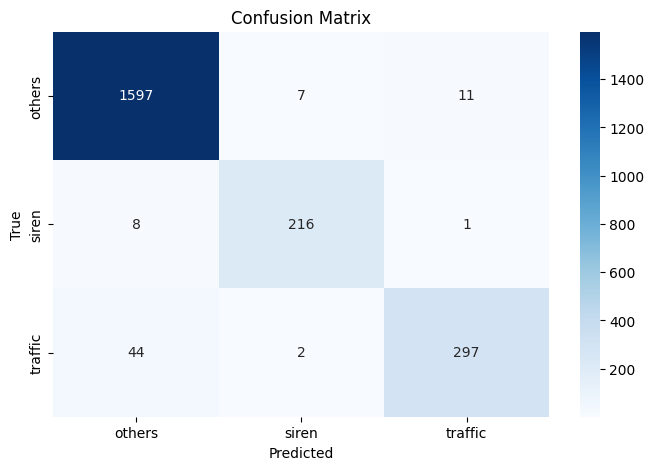

In [44]:
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['others', 'siren', 'traffic'], yticklabels=['others', 'siren', 'traffic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#12. Apply Ensemle Methods

In [42]:
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train.argmax(axis=1))
y_pred_rf = clf.predict(X_test)
print(classification_report(y_true_labels, y_pred_rf, labels=[0, 1, 2], target_names=['others', 'siren', 'traffic']))

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


              precision    recall  f1-score   support

      others       0.97      0.99      0.98      1615
       siren       0.98      0.93      0.95       225
     traffic       0.98      0.89      0.93       343

    accuracy                           0.97      2183
   macro avg       0.98      0.94      0.96      2183
weighted avg       0.97      0.97      0.97      2183



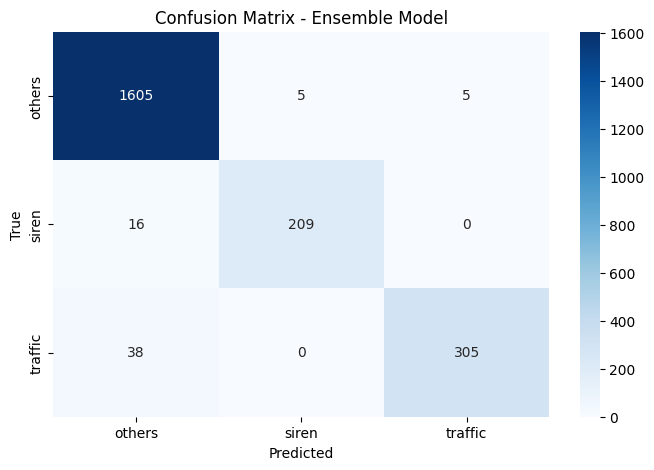

In [45]:
conf_matrix_rf = confusion_matrix(y_true_labels, y_pred_rf, labels=[0, 1, 2])
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['others', 'siren', 'traffic'], yticklabels=['others', 'siren', 'traffic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

#13. Save the model

In [ ]:
model.save('modelFullData.h5')

#Apply on sample data points (run it before the full code)

In [46]:
sample_data = filtered_data.groupby('target').apply(lambda x: x.sample(1)).reset_index(drop=True)
remaining_samples = filtered_data[~filtered_data.index.isin(sample_data.index)]
sample_data = pd.concat([sample_data, remaining_samples.sample(1500 - len(sample_data))], ignore_index=True)
sample_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,target
0,165529-2-0-70.wav,165529,35.000000,39.000000,2,7,2,children_playing,others
1,90014-8-0-3.wav,90014,1.500000,5.500000,1,3,8,siren,siren
2,195451-5-0-11.wav,195451,7.749062,11.749062,1,3,5,engine_idling,traffic
3,156634-5-0-8.wav,156634,4.000000,8.000000,1,5,5,engine_idling,traffic
4,128160-5-0-1.wav,128160,0.500000,4.500000,1,4,5,engine_idling,traffic


In [47]:
sample_data['target'].value_counts()

,count
target,
others,1078
traffic,236
siren,186


In [48]:
features, labels = parser(sample_data)
print(features.shape)
print(labels.shape)

data = pd.DataFrame(features, columns=['feature_' + str(i) for i in range(features.shape[1])])
data['label'] = np.argmax(labels, axis=1)
data.to_csv('sample_extracted_dataset.csv', index=False)
data.head()


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1379
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(1500, 161)
(1500, 3)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,label
0,-357.601624,146.460754,-24.784243,23.819715,-1.257452,23.814173,6.439843,21.931259,3.885100,4.713653,...,3.610536e-08,18.517822,11.952469,15.166444,16.870709,17.577188,17.116401,40.735042,1159.912181,0
1,-360.374481,146.885025,-33.683075,22.702696,-4.089760,21.906319,2.014030,10.666551,-15.696366,8.155653,...,8.785295e-09,17.125933,12.378068,21.687994,26.095719,27.680616,24.636498,55.321875,1402.067116,1
2,-110.042244,89.797379,-17.248880,27.079872,-11.416343,26.738073,-9.853734,3.580893,-9.191999,12.271019,...,5.850771e-07,15.744555,12.330625,14.100111,15.376103,16.718431,16.718356,45.370245,2541.219888,2
3,-343.419647,124.489265,-10.924706,69.173843,-2.049847,23.265137,14.020351,16.798977,4.877376,9.626954,...,5.537741e-08,27.977009,13.877939,14.481803,15.053424,15.037332,19.064706,48.615374,1207.806096,2
4,-316.695435,82.748787,-47.221958,19.524817,-20.949776,39.047928,-10.178570,32.097454,-15.071705,8.286366,...,1.534280e-09,22.392580,14.764838,13.841032,15.863139,15.529016,16.225678,43.515411,2795.991286,2


In [49]:
data  = pd.read_csv('sample_extracted_dataset.csv')
data['label'].value_counts()

,count
label,
0,1078
2,236
1,186


In [50]:
data.shape

(1500, 162)

In [51]:
data.isnull().sum()

,0
feature_0,0
feature_1,0
feature_2,0
feature_3,0
feature_4,0
...,...
feature_157,0
feature_158,0
feature_159,0
feature_160,0


In [52]:
data_null=data[data.isnull().any(axis=1)]
data_null

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,label


In [53]:
labels.sum()

1500

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

In [55]:
X_train.shape

(1125, 161)

In [56]:
y_train.shape

(1125, 3)

In [57]:
'''from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)'''

"from sklearn.impute import SimpleImputer\n\nimputer = SimpleImputer(strategy='mean')\nX_train = imputer.fit_transform(X_train)\nX_test = imputer.transform(X_test)"

In [58]:
'''from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42)

X_train = imputer.fit_transform(X_train)

X_test = imputer.transform(X_test)'''

'from sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nimputer = IterativeImputer(random_state=42)\n\nX_train = imputer.fit_transform(X_train)\n\nX_test = imputer.transform(X_test)'

In [59]:
'''smote = SMOTE(random_state=42, k_neighbors=1)
X_train, y_train = smote.fit_resample(X_train, y_train)'''

'smote = SMOTE(random_state=42, k_neighbors=1)\nX_train, y_train = smote.fit_resample(X_train, y_train)'

In [60]:
'''class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)'''

"class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))\nclass_weights_dict = dict(enumerate(class_weights))\nprint(class_weights_dict)"

In [61]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(256, activation='relu', input_shape=(features.shape[1],)),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(labels.shape[1], activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [63]:
history = model.fit(X_train, y_train,
                    epochs=200, batch_size=150,
                    validation_data=(X_test, y_test)
                    #class_weight=class_weights_dict,
                    #callbacks=[early_stopping]
                    )

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3345 - loss: 1.7402 - val_accuracy: 0.7040 - val_loss: 3.5263
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4021 - loss: 1.4855 - val_accuracy: 0.6987 - val_loss: 2.7026
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4209 - loss: 1.3509 - val_accuracy: 0.6987 - val_loss: 2.0245
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5087 - loss: 1.1934 - val_accuracy: 0.6933 - val_loss: 1.6897
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4806 - loss: 1.1873 - val_accuracy: 0.6880 - val_loss: 1.4988
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5129 - loss: 1.1418 - val_accuracy: 0.6693 - val_loss: 1.3876
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5483 - loss: 1.0312 - val_accuracy: 0.6560 - val_loss: 1.1626
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5798 - loss: 0.9795 - val_accuracy: 0.6507 - val_loss:

In [64]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │          41,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,043 (984.55 KB)

 Trainable params: 83,715 (327.01 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 167,432 (654.04 KB)

In [65]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8475 - loss: 0.5939 
Test Loss: 0.6447
Test Accuracy: 0.8533


In [66]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       261
           1       0.86      0.66      0.75        58
           2       0.93      0.50      0.65        56

    accuracy                           0.85       375
   macro avg       0.88      0.71      0.77       375
weighted avg       0.86      0.85      0.84       375



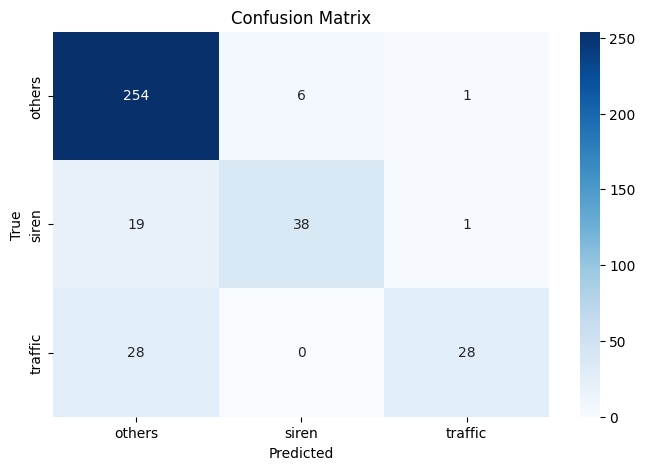

In [72]:
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['others', 'siren', 'traffic'], yticklabels=['others', 'siren', 'traffic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [68]:
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train.argmax(axis=1))
y_pred_rf = clf.predict(X_test)
print(classification_report(y_true_labels, y_pred_rf, labels=[0, 1, 2], target_names=['others', 'siren', 'traffic']))

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


              precision    recall  f1-score   support

      others       0.96      0.75      0.84       261
       siren       0.62      0.86      0.72        58
     traffic       0.54      0.88      0.67        56

    accuracy                           0.79       375
   macro avg       0.71      0.83      0.74       375
weighted avg       0.85      0.79      0.80       375



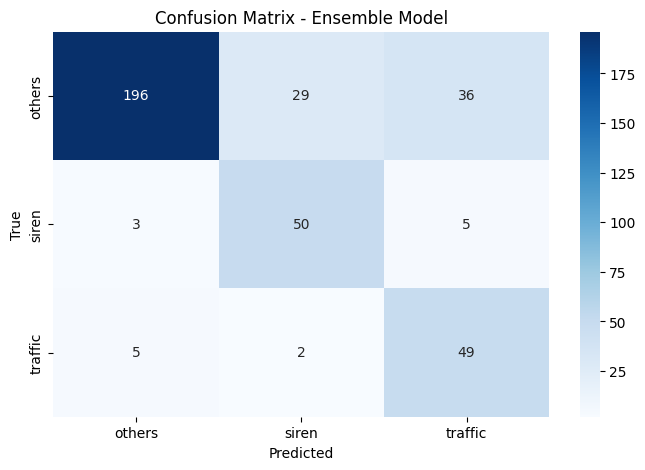

In [73]:
conf_matrix_rf = confusion_matrix(y_true_labels, y_pred_rf, labels=[0, 1, 2])
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['others', 'siren', 'traffic'], yticklabels=['others', 'siren', 'traffic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

In [70]:
model.save('model.h5')